In [1]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


- Tester tous les modèles sans gridsearchCV (1 ou 2 par grandes familles)
- Selectionner les meilleurs modèles car ce ne sont pas les hyperparamètres qui changent beaucoup. 
- Tester les valeurs extrêmes des hyperparamètres pour savoir dans quel direction aller. 
- Ensuite on peut choisir le meilleur modèle et faire évoluer les hyperparamètres. 
- Un fois que le gridsearchCV est terminé, on n'en fait plus et on reste sur les valeurs selectionnées. 
- Il faut trouver trouver des modèles avec un features importance globale et locale (pas de blackbox)

Pour le déséquilibre, regarder les modèles qui intègrent les déséquilibres. Ou alors, créer des faux clients qui n'auraient pas et de crétit (regarder SMOTE) Data Augmentation

DataDRIFT
Introduction de la notion de temps en se plaçant dans le passé. Se mettre comme si on était en 2022 par exemple. 

In [10]:
# Import des bibliothèques nécessaires
import os
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

Temps de chargement des données : 2.53 secondes


Évaluation des modèles:   0%|          | 0/7 [00:00<?, ?it/s]


Évaluation du modèle : DecisionTreeClassifier
Temps d'entraînement pour DecisionTreeClassifier: 12.35 secondes
Temps de prédiction pour DecisionTreeClassifier: 0.13 secondes


2024/11/02 11:12:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


DecisionTreeClassifier - AUC: 0.5404033165403638
DecisionTreeClassifier - Accuracy: 0.8544778546187699
DecisionTreeClassifier - Cost: 68460


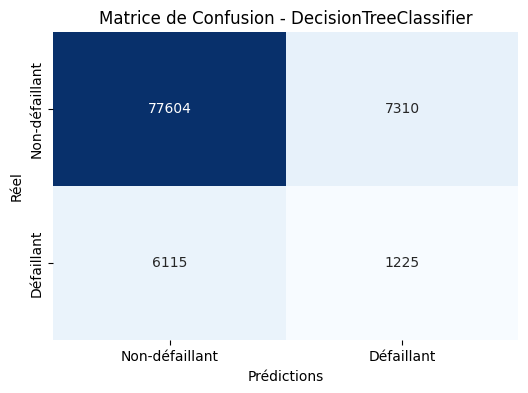

2024/11/02 11:12:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run puzzled-calf-528 at: http://127.0.0.1:5000/#/experiments/0/runs/3d1db2dcf29f480792f57d3acddff685.
2024/11/02 11:12:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.
Évaluation des modèles:  14%|█▍        | 1/7 [00:15<01:31, 15.22s/it]


Évaluation du modèle : RandomForestClassifier
Temps d'entraînement pour RandomForestClassifier: 50.05 secondes
Temps de prédiction pour RandomForestClassifier: 3.39 secondes


2024/11/02 11:12:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RandomForestClassifier - AUC: 0.721878149323576
RandomForestClassifier - Accuracy: 0.9204370542198712
RandomForestClassifier - Cost: 73310


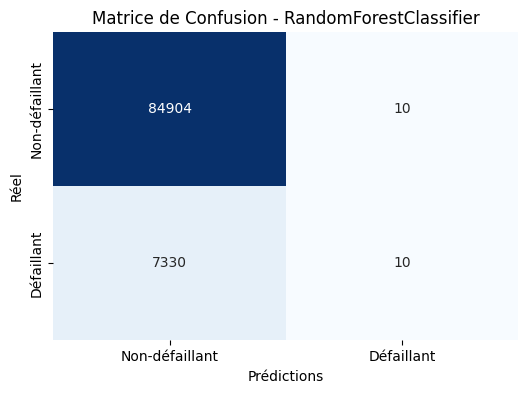

2024/11/02 11:12:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run upset-goose-935 at: http://127.0.0.1:5000/#/experiments/0/runs/cba26b20f7f44c89a967ba8e4247df8e.
2024/11/02 11:12:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.
Évaluation des modèles:  29%|██▊       | 2/7 [01:11<03:17, 39.47s/it]


Évaluation du modèle : ExtraTreesClassifier
Temps d'entraînement pour ExtraTreesClassifier: 45.33 secondes
Temps de prédiction pour ExtraTreesClassifier: 5.16 secondes


2024/11/02 11:13:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


ExtraTreesClassifier - AUC: 0.7093177668651321
ExtraTreesClassifier - Accuracy: 0.9204695731350402
ExtraTreesClassifier - Cost: 73343


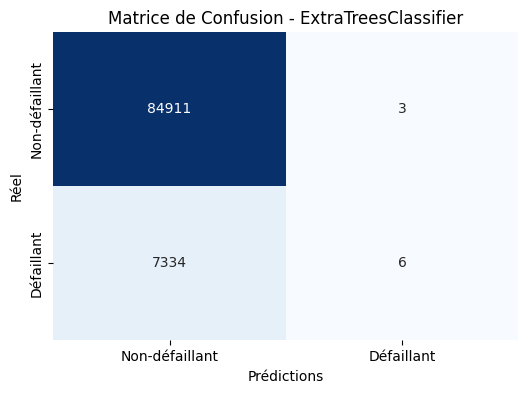

2024/11/02 11:13:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run smiling-fly-785 at: http://127.0.0.1:5000/#/experiments/0/runs/f23324670741421db8002533cb2aadbf.
2024/11/02 11:13:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.
Évaluation des modèles:  43%|████▎     | 3/7 [02:07<03:08, 47.09s/it]


Évaluation du modèle : GradientBoostingClassifier
Temps d'entraînement pour GradientBoostingClassifier: 244.01 secondes
Temps de prédiction pour GradientBoostingClassifier: 0.55 secondes


2024/11/02 11:18:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


GradientBoostingClassifier - AUC: 0.7581249122770086
GradientBoostingClassifier - Accuracy: 0.9203503371127539
GradientBoostingClassifier - Cost: 72526


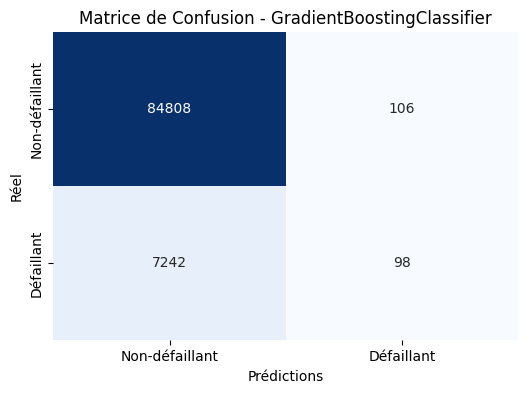

2024/11/02 11:18:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run amusing-horse-386 at: http://127.0.0.1:5000/#/experiments/0/runs/1ba71b97e1ca40048e43653ea82298be.
2024/11/02 11:18:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.
Évaluation des modèles:  57%|█████▋    | 4/7 [06:14<06:17, 125.83s/it]


Évaluation du modèle : XGBClassifier


/opt/anaconda3/envs/DS_PROJET_7/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:18:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Temps d'entraînement pour XGBClassifier: 3.30 secondes
Temps de prédiction pour XGBClassifier: 0.15 secondes


2024/11/02 11:18:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBClassifier - AUC: 0.75631631208341
XGBClassifier - Accuracy: 0.9201769028985193
XGBClassifier - Cost: 71003


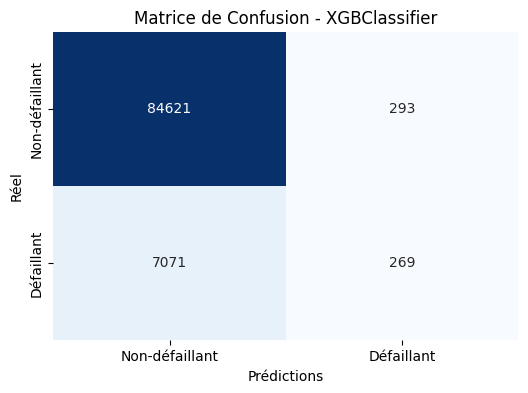

2024/11/02 11:18:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run luminous-horse-270 at: http://127.0.0.1:5000/#/experiments/0/runs/8b75108a0d6847609c77a023b79655c1.
2024/11/02 11:18:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.
Évaluation des modèles:  71%|███████▏  | 5/7 [06:19<02:44, 82.22s/it] 


Évaluation du modèle : LGBMClassifier
[LightGBM] [Info] Number of positive: 17485, number of negative: 197772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12873
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081228 -> initscore=-2.425771
[LightGBM] [Info] Start training from score -2.425771
Temps d'entraînement pour LGBMClassifier: 2.89 secondes
Temps de prédiction pour LGBMClassifier: 0.32 secondes


2024/11/02 11:18:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LGBMClassifier - AUC: 0.7634282359988651
LGBMClassifier - Accuracy: 0.9206430073492748
LGBMClassifier - Cost: 72085


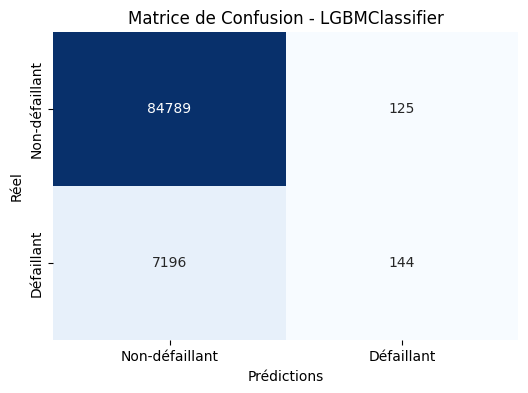

2024/11/02 11:18:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run blushing-croc-774 at: http://127.0.0.1:5000/#/experiments/0/runs/2442248055c84f30b3578b58bea51ebb.
2024/11/02 11:18:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.
Évaluation des modèles:  86%|████████▌ | 6/7 [06:24<00:55, 55.90s/it]


Évaluation du modèle : CatBoostClassifier
Temps d'entraînement pour CatBoostClassifier: 38.62 secondes
Temps de prédiction pour CatBoostClassifier: 7.14 secondes


2024/11/02 11:18:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


CatBoostClassifier - AUC: 0.768341877106114
CatBoostClassifier - Accuracy: 0.9204045353047022
CatBoostClassifier - Cost: 71297


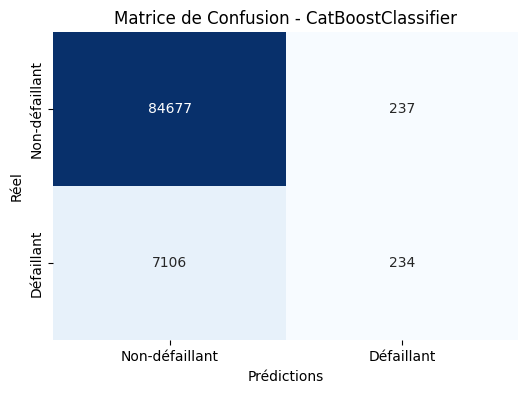

2024/11/02 11:18:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run peaceful-mink-686 at: http://127.0.0.1:5000/#/experiments/0/runs/bd7a2669210e4360afcde4a5b81c3489.
2024/11/02 11:18:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.
Évaluation des modèles: 100%|██████████| 7/7 [07:11<00:00, 61.62s/it]


In [8]:


# Configuration de l'URI MLFlow
os.environ["MLFLOW_TRACKING_URI"] = "http://127.0.0.1:5000"

# Charger les données
start_time = time.time()
app_train = pd.read_csv("Base De Donnée Prétraitée.csv")
print(f"Temps de chargement des données : {time.time() - start_time:.2f} secondes")

# Séparer les caractéristiques et la cible
train_labels = app_train['TARGET']
train = app_train.drop(columns=['TARGET'])

# Imputation et Normalisation des Données
imputer = SimpleImputer(strategy='median')
scaler = MinMaxScaler(feature_range=(0, 1))

# Imputer et normaliser les données
train = imputer.fit_transform(train)
train = scaler.fit_transform(train)

# Séparer les données en entraînement et validation
X_train, X_test, y_train, y_test = train_test_split(train, train_labels, test_size=0.3, random_state=0)

# Fonction pour tracer et loguer la matrice de confusion
def plot_and_log_confusion_matrix(model_name, y_test, y_pred):
    # Calcul de la matrice de confusion
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['Non-défaillant', 'Défaillant'], yticklabels=['Non-défaillant', 'Défaillant'])
    plt.xlabel('Prédictions')
    plt.ylabel('Réel')
    plt.title(f'Matrice de Confusion - {model_name}')
    
    # Enregistrement de la figure dans MLFlow
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.show()

# Définition de la fonction d'évaluation et de logging avec MLFlow, incluant les temps d'exécution
def evaluate_and_log_model(model, model_name, model_type):
    with mlflow.start_run():
        # Mesurer le temps d'entraînement du modèle
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time
        print(f"Temps d'entraînement pour {model_name}: {training_time:.2f} secondes")
        mlflow.log_metric("training_time", training_time)

        # Mesurer le temps de prédiction
        start_time = time.time()
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
        prediction_time = time.time() - start_time
        print(f"Temps de prédiction pour {model_name}: {prediction_time:.2f} secondes")
        mlflow.log_metric("prediction_time", prediction_time)

        # Évaluation des performances
        auc = roc_auc_score(y_test, y_proba)
        accuracy = accuracy_score(y_test, y_pred)
        
        # Matrice de confusion et calcul du coût métier
        conf_matrix = confusion_matrix(y_test, y_pred)
        fp = conf_matrix[0][1]
        fn = conf_matrix[1][0]
        cost = fp + 10 * fn  # Coût métier, avec FN pondéré 10 fois plus que FP

        # Enregistrement des métriques et paramètres dans MLFlow
        mlflow.log_metric("AUC", auc)
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("Cost", cost)
        mlflow.log_param("model_type", model_type)
        
        # Enregistrement du modèle
        mlflow.sklearn.log_model(model, model_name)
        
        # Affichage des résultats
        print(f"{model_name} - AUC: {auc}")
        print(f"{model_name} - Accuracy: {accuracy}")
        print(f"{model_name} - Cost: {cost}")
        
        # Tracer et loguer la matrice de confusion
        plot_and_log_confusion_matrix(model_name, y_test, y_pred)

# Liste des modèles à tester
models = [
    (DecisionTreeClassifier(class_weight='balanced', random_state=0), "DecisionTreeClassifier", "Decision Tree"),
    (RandomForestClassifier(class_weight='balanced', random_state=0), "RandomForestClassifier", "Ensemble - Random Forest"),
    (ExtraTreesClassifier(class_weight='balanced', random_state=0), "ExtraTreesClassifier", "Ensemble - Extra Trees"),
    (GradientBoostingClassifier(random_state=0), "GradientBoostingClassifier", "Ensemble - Boosting"),
    (XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0), "XGBClassifier", "Boosting - XGBoost"),
    (LGBMClassifier(random_state=0), "LGBMClassifier", "Boosting - LightGBM"),
    (CatBoostClassifier(verbose=0, random_state=0), "CatBoostClassifier", "Boosting - CatBoost")
]

# Exécuter chaque modèle avec une barre de progression
for model, model_name, model_type in tqdm(models, desc="Évaluation des modèles"):
    print(f"\nÉvaluation du modèle : {model_name}")
    evaluate_and_log_model(model, model_name, model_type)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[LightGBM] [Info] Number of positive: 17485, number of negative: 197772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12873
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Temps de GridSearchCV : 229.29 secondes
[LightGBM] [Info] Number of positive: 17485, number of negative: 197772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12873
[Lig

2024/11/02 16:56:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Meilleurs paramètres : {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 31}
AUC : 0.7645017263499618
Accuracy : 0.7109176837860689
Cost : 48089


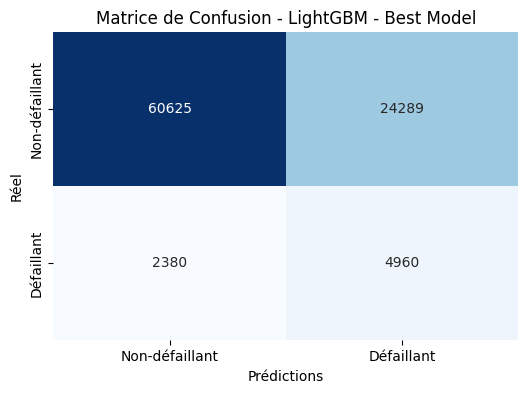

2024/11/02 16:56:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run hilarious-seal-885 at: http://127.0.0.1:5000/#/experiments/0/runs/899921bef72d4a189456c6010e0ea401.
2024/11/02 16:56:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


[LightGBM] [Info] Number of positive: 11657, number of negative: 131848
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.160711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13014
[LightGBM] [Info] Number of data points in the train set: 143505, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 11657, number of negative: 131848
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13014
[LightGBM] [Info] Number of data points in the train set: 143505, number of used features: 236
[LightGBM] [

In [11]:
# Paramètres de la grille pour le GridSearchCV
param_grid = {
    'num_leaves': [31, 50],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200]
}

# Initialisation du modèle LightGBM
lgbm = LGBMClassifier(class_weight='balanced', random_state=0)

# Configuration de GridSearchCV
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)

# Démarrer une expérimentation MLFlow
with mlflow.start_run():
    # Mesurer le temps de recherche de la grille
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    grid_search_time = time.time() - start_time
    print(f"Temps de GridSearchCV : {grid_search_time:.2f} secondes")
    mlflow.log_metric("grid_search_time", grid_search_time)
    
    # Enregistrer les meilleurs paramètres trouvés
    best_params = grid_search.best_params_
    for param, value in best_params.items():
        mlflow.log_param(param, value)
    
    # Meilleur modèle obtenu par GridSearchCV
    best_model = grid_search.best_estimator_

    # Entraîner le meilleur modèle sur l’ensemble d’entraînement complet
    start_time = time.time()
    best_model.fit(X_train, y_train)
    training_time = time.time() - start_time
    mlflow.log_metric("training_time", training_time)

    # Prédictions et évaluation sur l’ensemble de test
    start_time = time.time()
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]
    prediction_time = time.time() - start_time
    mlflow.log_metric("prediction_time", prediction_time)
    
    # Calcul des métriques
    auc = roc_auc_score(y_test, y_proba)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    fp = conf_matrix[0][1]
    fn = conf_matrix[1][0]
    cost = fp + 10 * fn  # Coût métier

    # Enregistrement des métriques dans MLFlow
    mlflow.log_metric("AUC", auc)
    mlflow.log_metric("Accuracy", accuracy)
    mlflow.log_metric("Cost", cost)
    
    # Enregistrement du modèle dans MLFlow
    mlflow.sklearn.log_model(best_model, "best_lightgbm_model")

    # Affichage des résultats
    print(f"Meilleurs paramètres : {best_params}")
    print(f"AUC : {auc}")
    print(f"Accuracy : {accuracy}")
    print(f"Cost : {cost}")

    # Tracer et loguer la matrice de confusion
    plot_and_log_confusion_matrix("LightGBM - Best Model", y_test, y_pred)